<a href="https://colab.research.google.com/github/hfarley/bigdata-finalproject/blob/main/BigDataFinal-Local.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Topics of Big Data - Final Project 
Spring 2023
Hannah Farley
Lucas Goldman

# This final project includes 3 tasks which seek to use data science strategies learned in CS52-66: Topics in Big Data to understand patterns and signifcant values in the data asscoiated with traffic incidients in Davidson County, Tennesse from 2017-2022. The 3 tasks are described below:



*   *Task 1*: Allows users to specify a single month and year and gets all accidents that occured during that period. Then, it displays a visualization in the form of a scatter plot where each dot represents the location of an incident in that month. 
*   *Task 2*: Allows users to specify a road segment in Davidson County by its segment ID (XDSegID), and shows the number of incidents that occured during every hour for that particular road.
* *Task 3*: This calculates the average emergency response time for each road segment in Davidson County and then sorts the data so you can see which roads have the fastest and slowest response times. 



This notebook creates a subset of 10,000 incidents from the incidents parquet data file provided. This smaller subset allows for quicker runs and easier debugging when working locally. 

To run locally:



*   Upload the incident parquet file
*   Run the setup and installation cells
* Run the cell to create the smaller subset 
* Run each cell (you must run the cell that creates the .py before submitting to spark locally)



# To start this notebook, run the following set up commands to install the necessary libraries

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
#install spark. we are using the one that uses hadoop as the underlying scheduler.
# !rm spark-3.2.4-bin-hadoop3.2.tgz 
!wget -q https://downloads.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
!tar xf  spark-3.2.4-bin-hadoop3.2.tgz
!ls -l

#Provides findspark.init() to make pyspark importable as a regular library.
os.environ["SPARK_HOME"] = "spark-3.2.4-bin-hadoop3.2"
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.7 pyspark-shell'

total 296072
-rw-r--r--  1 root root   1975841 Apr 29 21:21 nfd_incidents_xd_seg.parquet
drwxr-xr-x  1 root root      4096 Apr 27 13:35 sample_data
drwxr-xr-x 13 1000 1000      4096 Apr  9 21:17 spark-3.2.4-bin-hadoop3.2
-rw-r--r--  1 root root 301183180 Apr  9 21:35 spark-3.2.4-bin-hadoop3.2.tgz


In [ ]:
!pip install -q findspark pyspark
import findspark
findspark.init()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
#this creates a smaller sample dataset to work with locally

from pyspark.sql import SparkSession


spark = SparkSession.builder.appName("read_parquet").getOrCreate()

df = spark.read.parquet("nfd_incidents_xd_seg.parquet")

# create a smaller DataFrame with the first 10000 entries
df_small = df.limit(10000)

# write the output 
df_small.write.parquet("incidents_10000.parquet")
spark.stop()

# Task 1 - Monthly Incidents


Notes:


*   We start by loading in the smaller parquet file and dropping the unneccesary columns
*  We used local time as the time variable since that is more meaningful for someone trying to visualize the data
* We added columns for month and year for querying purposes - which are specified as command line arguments
* First specify the month and the year, then run the month_incidents cell and the cell immediately following to run locally. 
* The output is a new parquet file whose file name specifies the month and year which gets saved locally. 
* Running the following 2 cells will create and display the visualizaiton



In [ ]:
MONTH = 2
YEAR = 2017

In [ ]:
%%file month_incidents.py


import argparse
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month

if __name__ == '__main__':

  parser = argparse.ArgumentParser(description='Process some strings.')
  parser.add_argument('--monthArg', type=int, choices=range(1,13), help='month (1-12)', required=True)
  parser.add_argument('--yearArg', type=int, choices=range(2017,2023), help='year (2017-2022)', required=True)
  args = parser.parse_args()

  # replace this line with the s3 pass when testing over EMR
  conf = SparkConf().setAppName('month_incidents').set('spark.hadoop.validateOutputSpecs', False)
  sc = SparkContext(conf=conf).getOrCreate()
  spark = SparkSession(sc)

  
  try:

    incidents = spark.read.parquet("incidents_10000.parquet")

    incidents = incidents.drop("emdCardNumber", "time_utc", "response_time_sec", "day_of_week", "weekend_or_not", "Incident_ID", "Dist_to_Seg", "XDSegID")

    incidents = incidents.withColumn("year", year(incidents["time_local"]))
    incidents = incidents.withColumn("month", month(incidents["time_local"]))
    
    filtered_incidents = incidents.filter((incidents.year == args.yearArg) & (incidents.month == args.monthArg))
    
    filtered_incidents.show()
    
    filtered_incidents.write.parquet("incidents_{month}_{year}.parquet".format(month=args.monthArg, year=args.yearArg))


  finally:
    sc.stop()

  pass

Overwriting month_incidents.py


In [ ]:
#to test locally
!spark-submit --packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.7 month_incidents.py --monthArg MONTH --yearArg YEAR

:: loading settings :: url = jar:file:/content/spark-3.2.4-bin-hadoop3.2/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-streaming-kafka-0-8_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-60bb9722-875d-4f9c-a66b-c10808ba38fb;1.0
	confs: [default]
	found org.apache.spark#spark-streaming-kafka-0-8_2.11;2.4.7 in central
	found org.apache.kafka#kafka_2.11;0.8.2.1 in central
	found org.scala-lang.modules#scala-xml_2.11;1.0.2 in central
	found com.yammer.metrics#metrics-core;2.2.0 in central
	found org.slf4j#slf4j-api;1.7.16 in central
	found org.scala-lang.modules#scala-parser-combinators_2.11;1.1.0 in central
	found com.101tec#zkclient;0.3 in central
	found log4j#log4j;1.2.17 in central
	found org.apache.kafka#kafka-clients;0.8.2.1 in central
	found net.jpountz.lz4#lz4;1.2.0 in central
	found org.xerial.snapp

In [ ]:
!pip install geopandas pandas pyarrow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 44.7 MB/s eta 0:00:00


<Axes: >

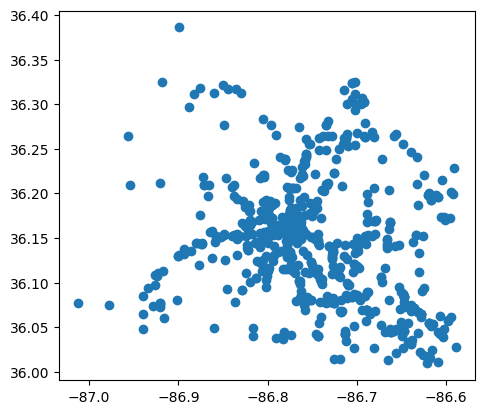

In [ ]:
import geopandas as gpd
import pandas as pd
import shapely


filename = "incidents_{month}_{year}.parquet".format(year=YEAR, month=MONTH)
incidents=pd.read_parquet(filename)

incidents['geometry']=incidents.geometry.apply(shapely.wkt.loads)
incidents = gpd.GeoDataFrame(incidents,geometry=incidents.geometry)
incidents.plot()


# Task 2 - Road Density Incidents

Notes:


*  Specify the command line argument - the road ID - in the local run line
*  This outputs and saves locally an html of the results



In [ ]:
%%file road_density_incidents.py

import argparse

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import hour
import plotly.express as px

if __name__ == '__main__':

  conf = SparkConf().setAppName('road_density_incidents').set('spark.hadoop.validateOutputSpecs', False)
  sc = SparkContext(conf=conf).getOrCreate()
  spark = SparkSession(sc)

  parser = argparse.ArgumentParser(description='Process some strings.')
  parser.add_argument('--XDSegID', type=float, help='Enter desired XDSegID', required=True)
  args = parser.parse_args()

  
  try:
    incidents = spark.read.parquet("incidents_10000.parquet")

    incidents = incidents.drop("emdCardNumber", "time_utc", "latitude", "longitude", "response_time_sec", "geometry", "day_of_week", "weekend_or_not", "Incident_ID", "Dist_to_Seg")
    incidents = incidents.withColumn("hour", hour(incidents["time_local"]))
    ex_id = args.XDSegID
    incidents = incidents.drop("time_local")
    incidents = incidents.filter(incidents.XDSegID == ex_id)
    hours = [val.hour for val in incidents.select('hour').collect()]

    fig = px.histogram(hours, nbins=24, title=f"Incident Hourly Density at Road Segment {ex_id}")
    fig.update_layout(
        xaxis_title="Hour", yaxis_title="Count"
    )
    fig.write_html("incident_segment_hour_density.html")
  

  finally:
    sc.stop()

  pass

Overwriting road_density_incidents.py


In [ ]:
!spark-submit --packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.7 road_density_incidents.py --XDSegID 1524393684.0

:: loading settings :: url = jar:file:/content/spark-3.2.4-bin-hadoop3.2/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-streaming-kafka-0-8_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-8f521d43-18de-4364-ad8f-1e5f88482839;1.0
	confs: [default]
	found org.apache.spark#spark-streaming-kafka-0-8_2.11;2.4.7 in central
	found org.apache.kafka#kafka_2.11;0.8.2.1 in central
	found org.scala-lang.modules#scala-xml_2.11;1.0.2 in central
	found com.yammer.metrics#metrics-core;2.2.0 in central
	found org.slf4j#slf4j-api;1.7.16 in central
	found org.scala-lang.modules#scala-parser-combinators_2.11;1.1.0 in central
	found com.101tec#zkclient;0.3 in central
	found log4j#log4j;1.2.17 in central
	found org.apache.kafka#kafka-clients;0.8.2.1 in central
	found net.jpountz.lz4#lz4;1.2.0 in central
	found org.xerial.snapp

# Task 3 - Average Road Response Time

Notes:


*   Since this queries average response times for all roads, no command line arguments are needed
*   When running locally it prints the first 20 rows of the output table



In [ ]:
%%file road_avg_response.py

from pyspark import SparkContext, SparkConf
from operator import add
from pyspark.sql import SparkSession


if __name__ == '__main__':

  conf = SparkConf().setAppName('month_incidents').set('spark.hadoop.validateOutputSpecs', False)
  sc = SparkContext(conf=conf).getOrCreate()
  spark = SparkSession(sc)

  
  try:

    incidents = spark.read.parquet("incidents_10000.parquet")

    incidents = incidents.drop("latitude", "longitude", "emdCardNumber", "time_utc", "day_of_week", "weekend_or_not", "Incident_ID", "geometry")
    incidents = incidents.na.drop(subset=["response_time_sec","XDSegID"])
    incidents = incidents.rdd
    seg_response_sum = incidents.map(lambda x: (x.XDSegID, x.response_time_sec)).reduceByKey(lambda a, b: a + b)
    seg_count = incidents.map(lambda x: (x.XDSegID, 1)).reduceByKey(lambda a, b: a + b)

    join = seg_response_sum.join(seg_count)
    output = join.map(lambda a: (a[0], a[1][0]/a[1][1]))
    output = output.sortBy(lambda x: x[1], ascending=False)
    df = output.toDF(['XSegID', 'Average Response Time'])
    df.show()

  finally:
    sc.stop()

  pass

Overwriting road_avg_response.py


In [ ]:
!spark-submit --packages org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.7 road_avg_response.py

:: loading settings :: url = jar:file:/content/spark-3.2.4-bin-hadoop3.2/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml
Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.spark#spark-streaming-kafka-0-8_2.11 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-d6b7a40a-e73e-41e7-988a-fd14375f5886;1.0
	confs: [default]
	found org.apache.spark#spark-streaming-kafka-0-8_2.11;2.4.7 in central
	found org.apache.kafka#kafka_2.11;0.8.2.1 in central
	found org.scala-lang.modules#scala-xml_2.11;1.0.2 in central
	found com.yammer.metrics#metrics-core;2.2.0 in central
	found org.slf4j#slf4j-api;1.7.16 in central
	found org.scala-lang.modules#scala-parser-combinators_2.11;1.1.0 in central
	found com.101tec#zkclient;0.3 in central
	found log4j#log4j;1.2.17 in central
	found org.apache.kafka#kafka-clients;0.8.2.1 in central
	found net.jpountz.lz4#lz4;1.2.0 in central
	found org.xerial.snapp